/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2011_SixDataset_CONUS_0101.csv
/DeepLearning/mnt/shixiansheng/data_fusion/output/DFT_Test/2011_TransCONUS.csv


/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:76: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


X-axis Key_Periods: ['2011-01-01']
Y-axis Key_Periods: ['2011-01-01']


  0%|          | 0/1 [00:00<?, ?it/s]

/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2011_SixDataset_CONUS_0101.csv
/DeepLearning/mnt/shixiansheng/data_fusion/output/DFT_Test/2011_TransCONUS.csv


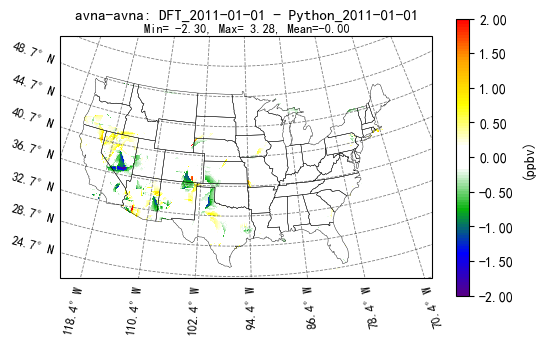

Done!


In [4]:
import os
import re
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_conc = cmaps.WhiteBlueGreenYellowRed
cmap_delta = cmaps.ViBlGrWhYeOrRe


def extract_key_period(period):
    """
    Extract key period (e.g., JFM, AMJ) from the full period string.
    """
    # key_periods = ["2011-07-01","2011-07-02","2011-07-03","2011-07-04","2011-07-05",
    #                "2011-07-06" ,"2011-07-10","2011-07-14","2011-07-19","2011-07-21","2011-07-25"]  # Add more if needed
    key_periods = ["2011-01-01"]  # Add more if needed
    for key in key_periods:
        if key in period:
            return key
    return None


def get_prefix(filename):
    """
    Determine the prefix based on the filename.
    If the filename contains 'daily' or 'IA', return 'IA'; otherwise, return 'AI'.
    """
    print(filename)
    if "daily" in filename.lower() or "FtA" in filename:
        return ""
    return ""


def get_year(filename):
    """
    Extract the year from the filename (assuming the year is in the range 2011-2020).
    """
    match = re.search(r"(20[1-2][0-9])", filename)  # Match years between 2011 and 2020
    if match:
        return match.group(1)
    return None


def get_axis_label(filename, period=None, year=None):
    """
    Generate the axis label based on the filename.
    - If the filename contains 'DFT', the label is 'DFT'.
    - If the filename does not contain 'DFT', the label is 'Python'.
    - Combine with the prefix (IA or AI), period, and year to form the final label.
    """
    prefix = get_prefix(filename)
    if "DFT" in filename:
        label = "DFT"
    else:
        label = "Python"
    
    # Add period and year to the label if provided
    if period and year:
        return f"{label}_{period}"
    elif period:
        return f"{label}_{period}"
    elif year:
        return f"{label}"
    return f"{prefix}_{label}"

#137241  54024   83217  -83217*2=166434

def plot_us_map(
    fusion_output_file_x,
    fusion_output_file_y,
    model_file,
    save_path=None,
    boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file_x: the data fusion output file for the x-axis
    @param {string} fusion_output_file_y: the data fusion output file for the y-axis
    @param {string} model_file: the model file used for data fusion
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @return None
    """
    # Load model attributes
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    
    # Read both x-axis and y-axis data
    df_data_x = pd.read_csv(fusion_output_file_x)
    df_data_y = pd.read_csv(fusion_output_file_y)
    
    # Check if the required columns exist
    if "Timestamp" not in df_data_x.columns or "Timestamp" not in df_data_y.columns:
        print("The data fusion files do not contain the Period column!")
        return
    # if "vna_ozone" not in df_data_x.columns or "vna_ozone" not in df_data_y.columns:
    #     print("The data fusion files do not contain the vna_ozone column!")
        return
    # if "evna_ozone" not in df_data_x.columns or "evna_ozone" not in df_data_y.columns:
    #     print("The data fusion files do not contain the evna_ozone column!")
    #     return
    
    # Extract key periods (e.g., JFM, AMJ) from the Period column
    df_data_x["Key_Period"] = df_data_x["Timestamp"].apply(extract_key_period)
    df_data_y["Key_Period"] = df_data_y["Timestamp"].apply(extract_key_period)
    
    # Drop rows where Key_Period is None
    df_data_x = df_data_x.dropna(subset=["Key_Period"])
    df_data_y = df_data_y.dropna(subset=["Key_Period"])
    
    # Debug: Print unique Key_Periods
    print("X-axis Key_Periods:", df_data_x["Key_Period"].unique())
    print("Y-axis Key_Periods:", df_data_y["Key_Period"].unique())
    
    # Extract year from filenames
    year_x = get_year(fusion_output_file_x)
    year_y = get_year(fusion_output_file_y)
    
    if year_x != year_y:
        print("Warning: The years in the input files do not match!")
        return
    
    year = year_x  # Use the year from the x-axis file (assuming they match)
    
    # Process each key period
    key_periods = df_data_x["Key_Period"].unique()
    for key_period in tqdm(key_periods):
        # Filter data for the current key period
        df_x_period = df_data_x[df_data_x["Key_Period"] == key_period]
        df_y_period = df_data_y[df_data_y["Key_Period"] == key_period]
        
        if len(df_x_period) == 0 or len(df_y_period) == 0:
            print(f"No data found for period {key_period} in one of the files!")
            continue
        
        # Generate axis labels with period and year information
        x_label = get_axis_label(fusion_output_file_x, key_period, year)  # e.g., AI_DFT_JFM_2011
        y_label = get_axis_label(fusion_output_file_y, key_period, year)  # e.g., IA_Python_JFM_2011
        
        # Reshape data to match the grid
        grid_ds_ozone_x = df_x_period["avna_ozone"].values.reshape(longitudes.shape)
        grid_ds_ozone_y = df_y_period["avna_ozone"].values.reshape(longitudes.shape)
        
        # Calculate differences (y - x)
        # grid_vna_diff = grid_vna_ozone_y - grid_vna_ozone_x
        # grid_evna_diff = grid_evna_ozone_y - grid_evna_ozone_x
        grid_avna_diff = grid_ds_ozone_y - grid_ds_ozone_x
        
        # Prepare data for plotting
        dict_data = {}
        # get_multiple_data(
        #     dict_data,
        #     dataset_name=f"VNA",
        #     variable_name=f"{y_label} - {x_label}",  # y - x
        #     grid_x=longitudes,
        #     grid_y=latitudes,
        #     grid_concentration=grid_vna_diff,
        #     is_delta=True,
        #     cmap=cmap_delta,
        # )
        # get_multiple_data(
        #     dict_data,
        #     dataset_name=f"eVNA",
        #     variable_name=f"{y_label} - {x_label}",  # y - x
        #     grid_x=longitudes,
        #     grid_y=latitudes,
        #     grid_concentration=grid_evna_diff,
        #     is_delta=True,
        #     cmap=cmap_delta,
        # )
        get_multiple_data(
            dict_data,
            dataset_name=f"avna-avna:",
            variable_name=f"{y_label} - {x_label}",  # y - x
            grid_x=longitudes,
            grid_y=latitudes,
            grid_concentration=grid_avna_diff,
            is_delta=True,
            cmap=cmap_delta,
        )
        
        # Plot the maps
        fig = show_maps(
            dict_data,
            unit="ppbv",
            cmap=cmap_conc,
            show_lonlat=True,
            projection=proj,
            is_wrf_out_data=True,
            boundary_file=boundary_json_file,
            show_original_grid=True,
            panel_layout=None,  # Automatically determine layout
            delta_map_settings={
                "cmap": cmap_delta,
                "value_range": (-2, -2),  # Let the function auto-scale
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f",
            },
            title_fontsize=11,
            xy_title_fontsize=9,
            show_dependenct_colorbar=True,
            show_domain_mean=True,#用于不规则剔除
        )

        # Save the plot with year and period prefix
        if save_path is not None:
            save_file = os.path.join(save_path, f"{year}_{key_period}_diff_data_fusion.png")
            fig.savefig(save_file, dpi=300, bbox_inches="tight")
            print(f"The data fusion plot for {year} {key_period} is saved to {save_file}")


if __name__ == "__main__":
    # 定义基础保存路径
    base_save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output"
    
    # 输入文件
    #IA and Python refers to y
    # fusion_output_file_x = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2011_SixDataset_CONUS_0102.csv"
    fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/DFT_Test/2011_TransCONUS.csv"
    # fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_daily_DF_seasonal_O3-MDA8.csv"
    # fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/seasonal_fused_data_2011_AnnualApr.csv"
    # fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/DFT_Test/DFT_2011-01-02_aVNA_daily_TransCONUS.csv"
    fusion_output_file_x = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_Data_WithoutCV/2011_SixDataset_CONUS_0101.csv"
    
    # 生成轴标签
    x_label = get_axis_label(fusion_output_file_x)  # 例如：AI_DFT
    y_label = get_axis_label(fusion_output_file_y)  # 例如：IA_Python
    
    # 提取年份
    year = get_year(fusion_output_file_x)  # 例如：2011
    
    
    # 其他代码
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    
    plot_us_map(
        fusion_output_file_x,
        fusion_output_file_y,
        model_file,
    )
    print("Done!")